In [1]:
!pip install \
    "fastapi>=0.128.0" \
    "langchain>=1.2.3" \
    "langchain-openai>=1.1.7" \
    "langgraph>=1.0.5" \
    "pydantic-settings>=2.12.0" \
    "python-dotenv>=1.2.1" \
    "uvicorn>=0.40.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.123.10
    Uninstalling fastapi-0.123.10:
      Successfully uninstalled fastapi-0.123.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.21.0 requires fastapi<0.124.0,>=0.115.0, but you have fastapi 0.128.0 which is incompatible.


# Imports

In [27]:
from langchain.agents import create_agent
from typing_extensions import TypedDict
from typing import List, Dict, Optional, TypedDict, Annotated
from langchain_core.messages import BaseMessage
from langchain_openai import ChatOpenAI
from langchain.agents.structured_output import ToolStrategy
from langgraph.checkpoint.memory import MemorySaver
import operator
import logging
from pprint import pprint


# Agent State

In [3]:
class AnswersSoFar(TypedDict):
    questions: Annotated[list[str], operator.add]
    answers:   Annotated[list[str], operator.add]


class AgentState(TypedDict):
    initial_description: str
    answers_so_far: AnswersSoFar
    iteration_count: int
    is_ready: bool               # set by question node when is_complete=True
    final_description: Optional[str]
    is_complete: bool            # final node sets this to True
    error: Optional[str]         # both nodes can write here

# Prompts

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.utils.input import print_text

In [5]:
# Prompt for asking clarifying questions
ASK_QUESTIONS_PROMPT = ChatPromptTemplate(
    [
        ("system",
            """You are an AI legal intake assistant. Your role is to gather information about a user's legal situation by asking clarifying questions.

            The user has provided this initial description:
            {initial_description}

            Previous Questions Asked:
            {previous_questions}

            Previous answers from the user:
            {previous_answers}

            Your task is to ask 1-3 specific, relevant questions that will help clarify the legal situation. Focus on gathering facts that would be important for a lawyer to know.

            Provide your response in the following JSON format:
            {{
                "reasoning": "Brief explanation of why you're asking these questions",
                "questions": ["question 1", "question 2", "question 3"],
                "is_complete": false
            }}

            IMPORTANT:
            - Ask specific, factual questions
            - Do not provide legal advice
            - Do not make assumptions about the law
            - If you have sufficient information to create a comprehensive case summary, set is_complete to true
            - Limit to 3 questions max to avoid overwhelming the user
            - Make sure questions are directly related to the legal matter at hand
            """)
    ]
)

In [6]:
results = ASK_QUESTIONS_PROMPT.invoke(
    {
        'previous_answers': "No Answers provided yet.",
        'previous_questions': "No Questions provided yet.",
        'initial_description': "I want to apply for a deviorce"
    }
)

print_text(results.messages[-1].content)

You are an AI legal intake assistant. Your role is to gather information about a user's legal situation by asking clarifying questions.

            The user has provided this initial description:
            I want to apply for a deviorce

            Previous Questions Asked:
            No Questions provided yet.

            Previous answers from the user:
            No Answers provided yet.

            Your task is to ask 1-3 specific, relevant questions that will help clarify the legal situation. Focus on gathering facts that would be important for a lawyer to know.

            Provide your response in the following JSON format:
            {
                "reasoning": "Brief explanation of why you're asking these questions",
                "questions": ["question 1", "question 2", "question 3"],
                "is_complete": false
            }

            IMPORTANT:
            - Ask specific, factual questions
            - Do not provide legal advice
            - Do 

In [7]:
# Structured output format for question-asking
STRUCTURED_QUESTION_RESPONSE_FORMAT = {
    "type": "object",
    "properties": {
        "reasoning": {
            "type": "string",
            "description": "Brief explanation of why you're asking these questions"
        },
        "questions": {
            "type": "array",
            "items": {
                "type": "string"
            },
            "description": "1-3 specific, relevant questions to ask the user"
        },
        "is_complete": {
            "type": "boolean",
            "description": "True if you have enough information to create a final description, false otherwise"
        }
    },
    "required": ["reasoning", "questions", "is_complete"]
}

In [8]:
FINALIZE_DESCRIPTION_PROMPT = ChatPromptTemplate(
    [
        ("system","""
You are an AI legal assistant. Based on the following information, create a professional, comprehensive case description that a lawyer could use to understand the situation:

Initial description: {initial_description}

Questions and answers:
  Questions:
    {all_questions}
  Answers:
    {all_answers}

Your task is to synthesize this information into a clear, professional case summary that includes:
1. The key facts of the situation
2. The legal issues involved (without offering legal advice)
3. Any relevant timelines or important details
4. The client's apparent goals or concerns

Format your response as a well-structured professional summary. Be thorough but concise. Do NOT provide legal advice or recommendations. Simply summarize the facts as presented.

IMPORTANT DISCLAIMERS TO INCLUDE AT THE END:
This is an AI-generated summary based solely on the information provided. It is NOT legal advice. Consult a qualified attorney for legal guidance.
"""
      )
  ]
)

# Nodes

In [9]:
from google.colab import userdata

In [10]:
llm = ChatOpenAI(
    api_key=userdata.get('OPENROUTER_API_KEY'),
    base_url="https://openrouter.ai/api/v1",
    model="x-ai/grok-4.1-fast",
)

In [ ]:
init_state = AgentState(
    initial_description="I want to apply for a divorce",
    iteration_count=0,
    answers_so_far={'questions': [], 'answers': []},
    is_ready=False,
    final_description=None,
    is_complete=False,
    error=None
)

## @node -- Ask Questions Node --

In [ ]:
init_state

{'initial_description': 'I want to apply for a divorce',
 'iteration_count': 0,
 'answers_so_far': {'questions': [], 'answers': []},
 'is_ready': False,
 'final_description': None,
 'is_complete': False}

In [ ]:
init_state['answers_so_far']['answers']

['No Answers provided yet.']

In [11]:
def ask_questions(state: AgentState) -> AgentState:

  print("---Executing Ask Questions Node---")
  if not state['answers_so_far']['answers']:
    state['answers_so_far']['answers'].append("No Answers provided yet.")
    state['answers_so_far']['questions'].append("No Questions provided yet.")

  prompt = ASK_QUESTIONS_PROMPT.invoke(
      {
          'initial_description': state['initial_description'],
          'previous_answers': state['answers_so_far']['answers'],
          'previous_questions': state['answers_so_far']['questions'],
      })

  strategy = ToolStrategy(STRUCTURED_QUESTION_RESPONSE_FORMAT)

  agent = create_agent(
        llm,
        tools=[],
        system_prompt=prompt.messages[-1].content,
        response_format=strategy,
    )

  try:
    result = agent.invoke({"messages": [{"role": "user", "content": " "}]})
    # FIX: Use extend instead of append to add individual questions from the list
    for question in result["structured_response"]["questions"]:
      state['answers_so_far']['questions'].append(question)
  except Exception as e:
    print(f'🚩 Error adding questions: {e}')
    return state

  state['iteration_count'] += 1
  # This line removes the initial placeholder, ensuring the list only contains actual questions.
  state['answers_so_far']['questions'].remove("No Questions provided yet.")

  return state

In [ ]:
test_state = ask_questions(init_state)

---Executing Ask Questions Node---
True
{'reasoning': 'To determine the jurisdiction for filing the divorce, identify if there are minor children involved which affects custody and support, and gather basic marriage details relevant to the process.', 'questions': ['In which state, province, or country do you and your spouse currently reside?', 'Do you have any children together, and if so, how old are they?', 'When and where were you married?'], 'is_complete': False}

 Questions: ['In which state, province, or country do you and your spouse currently reside?', 'Do you have any children together, and if so, how old are they?', 'When and where were you married?']


In [ ]:
init_state

{'initial_description': 'I want to apply for a divorce',
 'iteration_count': 1,
 'answers_so_far': {'questions': ['In which state, province, or country do you and your spouse currently reside?',
   'Do you have any children together, and if so, how old are they?',
   'When and where were you married?'],
  'answers': ['No Answers provided yet.']},
 'is_ready': False,
 'final_description': None,
 'is_complete': False}

## @node -- Ask Questions V2 --

In [12]:
import logging

logger = logging.getLogger(__name__)


def generate_questions_node(state: AgentState) -> dict:
    """
    Generates 1–3 new questions or decides we're ready.
    Uses create_react_agent so you can later plug in real tools (RAG/legal lookup).
    Pure node → returns delta only.
    """
    if state.get("is_ready", False) or state.get("is_complete", False):
        return {}  # already done

    # Build agent (you can move this outside / inject if preferred)
    prompt = ASK_QUESTIONS_PROMPT.invoke(
      {
          "initial_description": state['initial_description'],
          "previous_questions": "\n- " + "\n- ".join(state["answers_so_far"]["questions"]) if state["answers_so_far"]["questions"] else "None yet.",
          "previous_answers":   "\n- " + "\n- ".join(state["answers_so_far"]["answers"])   if state["answers_so_far"]["answers"] else "None provided.",
      })

    agent = create_agent(
          llm,
          tools=[],
          system_prompt=prompt.messages[-1].content,
          response_format=ToolStrategy(STRUCTURED_QUESTION_RESPONSE_FORMAT),
      )

    try:
        parsed = agent.invoke({"messages": [{"role": "user", "content": "Please continue the intake process now."}]})["structured_response"]

        new_questions = parsed.get("questions", [])
        reasoning = parsed.get("reasoning", "")
        is_complete_now = parsed.get("is_complete", False)

        update = {
            "answers_so_far": {
                "questions": new_questions,   # auto-appends thanks to reducer
            },
            "iteration_count": state["iteration_count"] + 1,
            "is_ready": is_complete_now,      # question node can set this
            "is_complete": False,             # only final node sets true
        }

        if is_complete_now:
            logger.info(f"Questions complete after {update['iteration_count']} iterations")
        else:
            logger.info(f"Asking {len(new_questions)} more questions (iter {update['iteration_count']})")

        return update

    except Exception as e:
        logger.exception("Question generation failed")
        return {
            "error": f"Question generation failed: {str(e)}",
            "iteration_count": state["iteration_count"] + 1,
        }

In [ ]:
init_state

{'initial_description': 'I want to apply for a divorce',
 'iteration_count': 0,
 'answers_so_far': {'questions': [], 'answers': []},
 'is_ready': False,
 'final_description': None,
 'is_complete': False,
 'error': None}

In [ ]:
generate_questions_node(init_state)

{'answers_so_far': {'questions': ['In which state or country do you currently reside, and for how long?',
   'When and where were you married?',
   'Do you have any children together, and if so, how old are they?']},
 'iteration_count': 1,
 'is_ready': False,
 'is_complete': False}

## @node -- Final Description Node --

In [43]:
def generate_final_description_node(state: AgentState) -> dict:
    """
    Only called when is_ready == True.
    Produces the polished professional description.
    Can also use agent/tools later (legal context, statutes...).
    """
    if not state.get("is_ready"):
        return {"error": "Final node called without is_ready=True"}

    prompt = FINALIZE_DESCRIPTION_PROMPT.invoke(
      {
          "initial_description": state['initial_description'],
          "all_questions": "\n- " + "\n- ".join(state["answers_so_far"]["questions"]) if state["answers_so_far"]["questions"] else "None yet.",
          "all_answers":   "\n- " + "\n- ".join(state["answers_so_far"]["answers"])   if state["answers_so_far"]["answers"] else "None provided.",
      }).messages[-1].content
    # print(f'Prompt: {prompt}')

    try:
        final_text = llm.invoke(prompt).content
        print(f'Final Description: {final_text}')
        return {
            "final_description": final_text.content if hasattr(final_text, "content") else str(final_text),
            "is_complete": True,
            "is_ready": False,  # cleanup
        }

    except Exception as e:
        return {"error": f"Final description generation failed: {str(e)}"}

In [ ]:
# Create an initial state for testing generate_final_description_node
test_final_state = AgentState(
    initial_description="I want to apply for a divorce, my spouse and I have been separated for 6 months.",
    answers_so_far={
        'questions': [
            "In which state, province, or country do you and your spouse currently reside?",
            "Do you have any children together, and if so, how old are they?",
            "When and where were you married?"
        ],
        'answers': [
            "We both reside in California.",
            "We have two children, ages 8 and 12.",
            "We were married in Las Vegas, Nevada, in 2010."
        ]
    },
    iteration_count=3,
    is_ready=True, # Set to True to allow the final description node to execute
    final_description=None,
    is_complete=False,
    error=None
)

print("Test final state created:")
print(test_final_state)

Test final state created:
{'initial_description': 'I want to apply for a divorce, my spouse and I have been separated for 6 months.', 'answers_so_far': {'questions': ['In which state, province, or country do you and your spouse currently reside?', 'Do you have any children together, and if so, how old are they?', 'When and where were you married?'], 'answers': ['We both reside in California.', 'We have two children, ages 8 and 12.', 'We were married in Las Vegas, Nevada, in 2010.']}, 'iteration_count': 3, 'is_ready': True, 'final_description': None, 'is_complete': False, 'error': None}


In [ ]:
# Call the generate_final_description_node with the test_final_state
final_description_result = generate_final_description_node(test_final_state)

print("\nResult from generate_final_description_node:")
print(final_description_result)

Prompt: 
You are an AI legal assistant. Based on the following information, create a professional, comprehensive case description that a lawyer could use to understand the situation:

Initial description: I want to apply for a divorce, my spouse and I have been separated for 6 months.

Questions and answers:
  Questions:
    
- In which state, province, or country do you and your spouse currently reside?
- Do you have any children together, and if so, how old are they?
- When and where were you married?
  Answers:
    
- We both reside in California.
- We have two children, ages 8 and 12.
- We were married in Las Vegas, Nevada, in 2010.

Your task is to synthesize this information into a clear, professional case summary that includes:
1. The key facts of the situation
2. The legal issues involved (without offering legal advice)
3. Any relevant timelines or important details
4. The client's apparent goals or concerns

Format your response as a well-structured professional summary. Be th

## @ConditionalEdge -- Route After Questions --

In [14]:
from langgraph.graph import StateGraph, START, END

In [17]:
# After questions → decide
def route_after_questions(state: AgentState) -> str:
    if state.get("error"):
        return END
    if state.get("is_ready"):
        return "generate_final"
    if state["iteration_count"] >= 3:  # safety
        return "generate_final"   # or END with partial
    return "generate_questions"       # loop back

# Dummy node
def get_answers(state: AgentState):
  pass

In [ ]:
route_after_questions(test_final_state)

'generate_final'

# LangGraph Workflow

In [23]:
workflow = StateGraph(state_schema=AgentState)

workflow.add_node("generate_questions", generate_questions_node)
workflow.add_node("generate_final", generate_final_description_node)
workflow.add_node("get_answers", get_answers)

# Entry
workflow.add_edge(START, "generate_questions")
workflow.add_edge("generate_questions", "get_answers")
workflow.add_conditional_edges(
    "get_answers",
    route_after_questions,
    {
        "generate_questions": "generate_questions",
        "generate_final": "generate_final",
        END: END
    }
)

workflow.add_edge("generate_final", END)

memory = MemorySaver()
graph = workflow.compile(interrupt_before=["get_answers"], checkpointer=memory)

In [49]:
from IPython.display import display, Image, Markdown

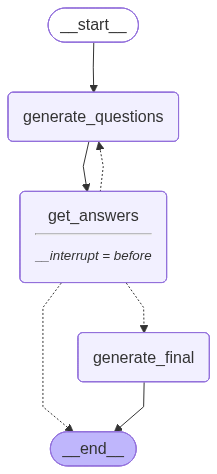

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
init_state = AgentState(
    initial_description="I want to apply for a divorce",
    iteration_count=0,
    answers_so_far={'questions': [], 'answers': []},
    is_ready=False,
    final_description=None,
    is_complete=False,
    error=None
)

In [38]:
config = {"configurable": {"thread_id": "1"}}

result = graph.invoke(init_state, config=config)
result

{'initial_description': 'I want to apply for a divorce',
 'answers_so_far': {'questions': ['In which state or country do you currently reside?',
   'Where and when were you legally married?',
   'Do you have any children together, and if so, how old are they?']},
 'iteration_count': 1,
 'is_ready': False,
 'final_description': None,
 'is_complete': False,
 'error': None}

In [39]:
state = graph.get_state(config)
state.values

{'initial_description': 'I want to apply for a divorce',
 'answers_so_far': {'questions': ['In which state or country do you currently reside?',
   'Where and when were you legally married?',
   'Do you have any children together, and if so, how old are they?']},
 'iteration_count': 1,
 'is_ready': False,
 'final_description': None,
 'is_complete': False,
 'error': None}

In [37]:
state.values['answers_so_far']['questions']

['In which state (or country, if outside the US) do you and your spouse currently reside?',
 'Approximately how long have you been married, and what is the date of your marriage?',
 'Do you have any minor children (under 18) with your spouse, and if so, how many?']

In [40]:
current_state = graph.get_state(config)
existing_questions = current_state.values['answers_so_far']['questions']

graph.update_state(config,
 {
    "answers_so_far": {
        'questions': existing_questions,
        'answers': [
            'We both reside in California.',
            'We were married oct/2010 in Las Vegas',
            'We have two children, ages 8 and 12.'
        ]
    },
    "iteration_count": 1,
    "is_ready": True
})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0f136a-6042-69f7-8006-f3e758beb98d'}}

In [41]:
graph.get_state(config)

StateSnapshot(values={'initial_description': 'I want to apply for a divorce', 'answers_so_far': {'questions': ['In which state or country do you currently reside?', 'Where and when were you legally married?', 'Do you have any children together, and if so, how old are they?'], 'answers': ['We both reside in California.', 'We were married oct/2010 in Las Vegas', 'We have two children, ages 8 and 12.']}, 'iteration_count': 1, 'is_ready': True, 'final_description': None, 'is_complete': False, 'error': None}, next=('get_answers',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f136a-6042-69f7-8006-f3e758beb98d'}}, metadata={'source': 'update', 'step': 6, 'parents': {}}, created_at='2026-01-14T10:49:06.430384+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f1362-7eab-62de-8005-5346c4f79ecd'}}, tasks=(PregelTask(id='dca8037e-5382-8027-7954-52aa900bd173', name='get_answers', path=('__pregel_pull', 'get_a

In [44]:
resumed_results = graph.invoke(None, config=config)
resumed_results

{'initial_description': 'I want to apply for a divorce',
 'answers_so_far': {'questions': ['In which state or country do you currently reside?',
   'Where and when were you legally married?',
   'Do you have any children together, and if so, how old are they?'],
  'answers': ['We both reside in California.',
   'We were married oct/2010 in Las Vegas',
   'We have two children, ages 8 and 12.']},
 'iteration_count': 1,
 'is_ready': False,
 'final_description': "# Case Summary: Divorce Inquiry\n\n## Client and Key Facts\n- **Client's Stated Goal**: The client seeks to apply for a divorce from their spouse.\n- **Parties Involved**: The client and their spouse, with two minor children in common.\n- **Residence**: Both spouses currently reside in California.\n- **Children**: Two children, aged 8 and 12.\n\n## Marital History\n- **Date and Location of Marriage**: Legally married in October 2010 in Las Vegas (Nevada).\n\n## Timeline of Relevant Events\n- Marriage: October 2010 (approximately 

In [50]:
display(Markdown(resumed_results['final_description']))

# Case Summary: Divorce Inquiry

## Client and Key Facts
- **Client's Stated Goal**: The client seeks to apply for a divorce from their spouse.
- **Parties Involved**: The client and their spouse, with two minor children in common.
- **Residence**: Both spouses currently reside in California.
- **Children**: Two children, aged 8 and 12.

## Marital History
- **Date and Location of Marriage**: Legally married in October 2010 in Las Vegas (Nevada).

## Timeline of Relevant Events
- Marriage: October 2010 (approximately 14 years ago).
- Children: Ages indicate births around 2012 and 2016.
- Current Status: Client initiating divorce proceedings as of the inquiry date.

## Potential Legal Issues
- Dissolution of marriage, given the California residency of both parties.
- Matters related to minor children, including custody, visitation, and support.
- Jurisdiction considerations due to out-of-state marriage location (Nevada).

## Client's Apparent Goals or Concerns
- Primary objective: Filing for divorce.
- No additional concerns explicitly stated beyond the desire to initiate divorce proceedings.

**IMPORTANT DISCLAIMERS:**  
This is an AI-generated summary based solely on the information provided. It is NOT legal advice. Consult a qualified attorney for legal guidance.

# Assets

In [ ]:
print(ChatOpenAI.__doc__)

Interface to OpenAI chat model APIs.

    ???+ info "Setup"

        Install `langchain-openai` and set environment variable `OPENAI_API_KEY`.

        ```bash
        pip install -U langchain-openai

        # or using uv
        uv add langchain-openai
        ```

        ```bash
        export OPENAI_API_KEY="your-api-key"
        ```

    ??? info "Key init args — completion params"

        | Param               | Type          | Description                                                                                                 |
        | ------------------- | ------------- | ----------------------------------------------------------------------------------------------------------- |
        | `model`             | `str`         | Name of OpenAI model to use.                                                                                |
        | `temperature`       | `float`       | Sampling temperature.                                                                 

In [ ]:
print(create_agent.__doc__)

Creates an agent graph that calls tools in a loop until a stopping condition is met.

    For more details on using `create_agent`,
    visit the [Agents](https://docs.langchain.com/oss/python/langchain/agents) docs.

    Args:
        model: The language model for the agent.

            Can be a string identifier (e.g., `"openai:gpt-4"`) or a direct chat model
            instance (e.g., [`ChatOpenAI`][langchain_openai.ChatOpenAI] or other another
            [LangChain chat model](https://docs.langchain.com/oss/python/integrations/chat)).

            For a full list of supported model strings, see
            [`init_chat_model`][langchain.chat_models.init_chat_model(model_provider)].

            !!! tip ""

                See the [Models](https://docs.langchain.com/oss/python/langchain/models)
                docs for more information.
        tools: A list of tools, `dict`, or `Callable`.

            If `None` or an empty list, the agent will consist of a model node without a
 